## Assessing the Impact of Drought on Corn and Soybean Productivity
#### COMP44447, Class Project, Winter 2025
#### Ket Poungnachith
#### Due: 17 Mar 2024

<font color="crimson"><i><b>NOTE: NO CSV files unrelated to this project should be saved in the directory, otherwise the code will override the files and produce inaccurate results.</b></i></font>

##### System Requirements:
This project requires Google Chrome to run Selenium WebDriver.

##### Install Google Chrome in WSL:
Run the following commands in your WSL terminal:
```bash
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
sudo apt update
sudo apt install -y ./google-chrome-stable_current_amd64.deb
google-chrome --version
```

In [1]:
import time
import pandas as pd
import numpy as np
import os
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
import statsmodels.api as sm
import statsmodels.formula.api as smf


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.chrome.options import Options

from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
%matplotlib inline

## INTRODUCTION

### Objective of the Study

The goal of this project is to analyze the relationship between drought severity and agricultural productivity, specifically focusing on crop yield and price trends for corn and soybeans in the top five producing states: Iowa, Illinois, Nebraska, Minnesota, and Indiana. By examining historical data, this study aims to determine whether higher drought severity correlates with lower crop yields and higher prices, providing valuable insights for farmers, policymakers, and the agricultural industry to develop better risk management strategies.

### Importance of Agriculture and Drought Analysis

Agriculture plays a crucial role in the U.S. economy, contributing approximately 5.5% to the Gross Domestic Product (GDP). In 2024, the value of U.S. corn production exceeded 13.92 billion USD, while soybean exports reached 24.58 billion USD (source: USDA). However, drought is a major challenge that significantly affects crop production and market dynamics. Understanding how drought severity impacts yield and price fluctuations is essential for ensuring food security, economic stability, and climate resilience in the agricultural sector.

### Methodology and Approach

This project follows a structured data science workflow:

1.  Data Acquisition: Drought and crop data are collected from official sources using web scraping techniques.
2.  Data Pre-Processing: The data is cleaned, processed, and merged to align average annual drought severity indices (Avg DSCI) with annual crop yield and price data.
3.  Data Visualization: The collected and merged data is visualized to display trends and distributions.
4.  Feature Engineering: New variables may be created to enhance the analysis, such as adjusted crop prices and yields based on the average DSCI.
5.  Exploratory Data Analysis (EDA): Summary statistics and visualizations are used to identify trends, correlations, and patterns in the data.
6.  Hypothesis Testing and Regression Analysis:
    *   Statistical Tests: Mann-Whitney U test, t-test, and Welch's t-test are applied to determine whether differences in yield and price across drought conditions are statistically significant.
    *   Multiple Regression: Assesses the impact of various independent variables on crop yield and price to identify key influencing factors.
    *   Interaction Term Regression: Evaluates how the drought index (DSCI) interacts with other variables affecting crop productivity.

### Hypotheses

To formally test the impact of drought, the study defines the following hypotheses:

1. Statistical Test
*   Null Hypothesis (H0): There is no significant difference in corn and soybean prices and yields between high and low drought conditions; drought does not impact corn or soybean prices and yields.
*   Alternative Hypothesis (H1): There is a significant difference in corn and soybean prices and yields between high and low drought conditions; drought does affect crop prices and yields, potentially increasing prices and reducing yields.

2. Multiple Regression Analysis
*   The null hypothesis (H0): None of the independent variables have a significant effect on the dependent variable.
*   Alternative Hypothesis (H1): At least one independent variable has a significant effect on the dependent variable.

## STEP 1: DATA ACQUISITION

#### Crop Data

The crop data used in this analysis is sourced from the United States Department of Agriculture (USDA).

The dataset includes yearly data (1996–2024) for corn and soybeans, with the following variables:
* Acres planted
*   Acres harvested
*   Price received (USD per bushel)
*   Yield (bushels per acre)

The following code retrieves the necessary data from the USDA's National Agricultural Statistics Service (NASS) website (https://www.nass.usda.gov/Statistics_by_Subject/index.php?sector=CROPS) if *crop_data.csv* does not already exist in the directory and stores it in both a DataFrame and a CSV file.

In [3]:
if not os.path.exists("crop_data.csv"):

    # start web driver with implicit wait
    driver = webdriver.Chrome()
    driver.implicitly_wait(5)  # global wait time for elements
    link = 'https://www.nass.usda.gov/Statistics_by_Subject/index.php?sector=CROPS'
    driver.get(link)
    driver_wait = 20
    # wait for page to fully load
    WebDriverWait(driver, driver_wait).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'body')))

    # specify variables for selected items
    group = 'FIELD CROPS'
    commodities = ['CORN', 'SOYBEANS']#, 'WHEAT']

    data_items = [
        ' - ACRES PLANTED',
        ', GRAIN - ACRES HARVESTED',
        ', GRAIN - PRICE RECEIVED, MEASURED IN $ / BU',
        ', GRAIN - YIELD, MEASURED IN BU / ACRE',
        ' - ACRES HARVESTED',
        ' - PRICE RECEIVED, MEASURED IN $ / BU',
        ' - YIELD, MEASURED IN BU / ACRE'
    ]

    time.sleep(5)

    # create an empty DataFrame to store all crop data
    all_dfs = pd.DataFrame()    

    for commodity in commodities:
        # locate the "Group" dropdown and select field crops
        dropdown_group = WebDriverWait(driver, driver_wait).until(EC.presence_of_element_located((By.ID, 'group_desc')))
        Select(dropdown_group).select_by_visible_text(group)

        # locate the "Commodity" dropdown
        dropdown_commodity = WebDriverWait(driver, driver_wait).until(EC.presence_of_element_located((By.ID, 'commodity_desc')))

        print(f"\nCollecting data for {commodity}...")

        # select the commodity from the dropdown
        Select(dropdown_commodity).select_by_visible_text(commodity)

        # generate the checkbox values dynamically for the selected commodity
        choose_data_items = [f"{commodity}{item}" for item in data_items]
        item_headers = []

        # unselect any previously selected checkboxes
        all_checkboxes = driver.find_elements(By.XPATH, "//input[@type='checkbox']")
        for checkbox in all_checkboxes:
            if checkbox.is_selected():
                checkbox.click()

        # select relevant checkboxes for this commodity
        for item in choose_data_items:
            try:
                checkboxes = driver.find_elements(By.XPATH, f"//input[@type='checkbox' and @value='{item}']")
                if checkboxes:
                    checkbox_item = checkboxes[0]  # take the first matching checkbox
                    if not checkbox_item.is_selected():
                        checkbox_item.click()
                        print(f"Selected checkbox: {item}")
                        item_headers.append(item)
                else:
                    print(f"Checkbox not found for: {item}, skipping...")

            except Exception as e:
                print(f"Error while selecting checkbox: {item}, error: {e}")



        # wait before clicking "Continue" to ensure checkboxes are registered
        time.sleep(3)

        try:
            continue_button = WebDriverWait(driver, driver_wait).until(
                EC.element_to_be_clickable((By.XPATH, "//div[@id='getdata']/a"))
            )
            continue_button.click()
            print(f"Clicked 'Continue' for {commodity}")
        except:
            print(f"Error: 'Continue' button not found for {commodity}. Skipping...")
            continue



        # wait before clicking "View More" to ensure data table loads
        time.sleep(4)

        try:
            more_button = WebDriverWait(driver, driver_wait).until(
                EC.element_to_be_clickable((By.XPATH, "//div[@id='viewmore']/a"))
            )
            more_button.click()
            print(f"Clicked 'View More' for {commodity}")
        except:
            print(f"Error: 'View More' button not found for {commodity}. Skipping...")
            continue

        # wait for table to load
        try:
            # table = WebDriverWait(driver, driver_wait).until(EC.presence_of_element_located((By.ID, "DataContainer")))
            table = WebDriverWait(driver, driver_wait).until(EC.presence_of_element_located((By.XPATH, "//*[@id='Data']")))

        except:
            print(f"Error: data table not found for {commodity}. Skipping...")
            continue



        # wait for the header table to appear
        time.sleep(5)

        header_table = WebDriverWait(driver, driver_wait).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='Data']/div[1]//table"))
        )

        # locate all header cells ('<th>' elements)
        header_cells = header_table.find_elements(By.TAG_NAME, "th")

        # extract and clean up the text from headers
        headers = [cell.get_attribute("innerHTML").replace("<br>", "").replace("VALUE", "").replace("\n", " ").strip() for cell in header_cells]

        # remove remaining HTML tags (like '<b>') if any
        import re
        headers = [re.sub(r"<.*?>", "", h) for h in headers]

        # print the extracted headers
        print("Extracted Headers:", headers)



        # extract data rows
        data_rows = WebDriverWait(driver, driver_wait).until(
            EC.presence_of_all_elements_located((By.XPATH, "//*[@id='dojox_grid__View_1']//div[contains(@class, 'dojoxGridRow')]"))
        )

        table_data = []
        for row in data_rows:
            # find all <td> cells inside each row
            cols = row.find_elements(By.TAG_NAME, "td")
            row_data = [col.text.strip() for col in cols]  # extract cell text
            if len(row_data) == len(headers):  # only keep rows that match header length
                table_data.append(row_data)

        # convert extracted data to a Pandas DataFrame
        df_filtered = pd.DataFrame(table_data, columns=headers)

        # display(df)



        time.sleep(5)
        # convert 'Year' column to numeric
        df_filtered["Year"] = pd.to_numeric(df_filtered["Year"], errors="coerce").dropna().astype("Int64")
        # df_filtered["Year"] = pd.to_datetime(df_filtered["Year"].astype(str) + "-01-01", format="%Y-%m-%d", errors="coerce")

        # filter for years 1995-2024
        # df_filtered = df_filtered[(df_filtered["Year"] >= 1995) & (df_filtered["Year"] <= 2024)]

        # keep only relevant columns
        columns_to_keep = ["Year", "Commodity"] + [col for col in df_filtered.columns if any(item in col for item in item_headers)]
        df_filtered = df_filtered[columns_to_keep]

        # replace invalid values with NaN
        df_filtered.replace(["None", "...", ""], pd.NA, inplace=True)

        # drop completely empty columns
        df_filtered.dropna(axis=1, how="all", inplace=True)



        time.sleep(5)
        # merge the new data into all_dfs DataFrame
        if all_dfs.empty:
            all_dfs = df_filtered
        else:
            all_dfs = pd.concat([all_dfs, df_filtered], ignore_index=True)

        # display(all_dfs)



        # go back to the main page before switching to the next commodity
        time.sleep(15)
        driver.get(link)
        WebDriverWait(driver, driver_wait).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'body')))


    # all_dfs.to_csv("crop_data_not_cleaned.csv", index=False)
    driver.quit()



    # helper function to normalize strings to remove extra whitespace and lower case
    def normalize(s):
        return " ".join(s.split()).lower()

    # normalize all column names in all_dfs and build a lookup dictionary
    all_dfs.columns = [col.strip() for col in all_dfs.columns]
    col_map = {normalize(col): col for col in all_dfs.columns}

    def extract_crop_data(row):
        # get the commodity in upper case to standardize
        commodity = row["Commodity"].upper()
        
        # define the expected normalized column keys
        if commodity == "CORN":
            planted_key = normalize(f"{commodity} - ACRES PLANTED  -")
            harv_key    = normalize(f"{commodity}, GRAIN - ACRES HARVESTED  -")
            price_key   = normalize(f"{commodity}, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU  -")
            yield_key   = normalize(f"{commodity}, GRAIN - YIELD, MEASURED IN BU / ACRE  -")
        elif commodity == "SOYBEANS":
            planted_key = normalize(f"{commodity} - ACRES PLANTED  -")
            harv_key    = normalize(f"{commodity} - ACRES HARVESTED  -")
            price_key   = normalize(f"{commodity} - PRICE RECEIVED, MEASURED IN $ / BU  -")
            yield_key   = normalize(f"{commodity} - YIELD, MEASURED IN BU / ACRE  -")
        else:
            planted_key = harv_key = price_key = yield_key = None

        # use the mapping to extract the value if the key is found; otherwise, assign NaN.
        acres_planted = row[col_map[planted_key]] if planted_key in col_map else np.nan
        acres_harvested = row[col_map[harv_key]] if harv_key in col_map else np.nan
        price = row[col_map[price_key]] if price_key in col_map else np.nan
        yield_bu = row[col_map[yield_key]] if yield_key in col_map else np.nan

        return pd.Series({
            "YEAR": row["Year"],
            "COMMODITY": row["Commodity"],
            "ACRES PLANTED": acres_planted,
            "ACRES HARVESTED": acres_harvested,
            "PRICE USD/BU": price,
            "YIELD BU/ACRE": yield_bu
        })

    # apply the extraction function row-wise to create crop_data_df.
    crop_data_df = all_dfs.apply(extract_crop_data, axis=1)

    # str to float
    crop_data_df['ACRES PLANTED'] = crop_data_df['ACRES PLANTED'].str.replace(',', '').astype(float)
    crop_data_df['ACRES HARVESTED'] = crop_data_df['ACRES HARVESTED'].str.replace(',', '').astype(float)
    # crop_data_df['PRICE USD/BU'] = crop_data_df['PRICE USD/BU'].str.replace(',', '').astype(float)
    crop_data_df['PRICE USD/BU'] = pd.to_numeric(crop_data_df['PRICE USD/BU'].astype(str).str.replace(',', ''),errors='coerce')
    crop_data_df['YIELD BU/ACRE'] = crop_data_df['YIELD BU/ACRE'].str.replace(',', '').astype(float)


    # sort the resulting DataFrame by YEAR and COMMODITY.
    crop_data_df.sort_values(["COMMODITY", "YEAR"], inplace=True)

    crop_data_df.to_csv("crop_data.csv", index=False)
    # print(crop_data_df.head())
else:
    print("crop_data.csv already exists in the directory. Continuing to the next task...")

crop_data.csv already exists in the directory. Continuing to the next task...


In [4]:
# check data type
df1 = pd.read_csv("crop_data.csv")
print(df1.dtypes)

YEAR                 int64
COMMODITY           object
ACRES PLANTED      float64
ACRES HARVESTED    float64
PRICE USD/BU       float64
YIELD BU/ACRE      float64
dtype: object


#### DSCI Data

The drought data used for this analysis is sourced from the U.S. Drought Monitor (USDM). The dataset includes data from the top five corn- and soybean-producing states in the U.S. The variable collected is DSCI (Drought Severity and Coverage Index).

The DSCI is a linear combination of weighted drought categories, ranging from 0 to 500, where 0 indicates no drought conditions and 500 signifies that the entire area is experiencing exceptional drought.

The formula for DSCI is:

*DSCI = 1D0 + 2D1 + 3D2 + 4D3 + 5D4*

Where:

D0 = Abnormally Dry

D1 = Moderate Drought

D2 = Severe Drought

D3 = Extreme Drought

D4 = Exceptional Drought

The following code retrieves weekly DSCI data (2000–2024) from the U.S. Drought Monitor website if DSCI_data.csv does not already exist in the directory. The collected data is then stored in both a DataFrame and a CSV file.



In [5]:
# get the directory of the current script or fallback to the current working directory
try:
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    script_dir = os.getcwd()

# set the download directory to the same directory as the script
download_dir = script_dir  # or use os.path.join(script_dir, "downloads") for a dedicated subfolder

# define the new file path for the downloaded csv
filename = "DSCI_data.csv"
new_file_path = os.path.join(download_dir, filename)

# if dsci_data.csv already exists, delete it before downloading a new one
if os.path.exists(new_file_path):
    # os.remove(new_file_path)
    print(f"{filename}v exists in the directory")

else:

    # create chrome options to use the specified download directory
    chrome_options = Options()
    prefs = {
        "download.default_directory": download_dir,  # set download directory
        "download.prompt_for_download": False,         # disable download prompt
        "download.directory_upgrade": True,
        "safebrowsing.enabled": True
    }
    chrome_options.add_experimental_option("prefs", prefs)

    # function to start the webdriver
    def start_driver():
        driver = webdriver.Chrome(options=chrome_options)
        driver.implicitly_wait(5)  # global wait time for elements
        return driver

    # start web driver
    driver2 = start_driver()
    driver_wait2 = 20

    # navigate to the target url
    link2 = 'https://droughtmonitor.unl.edu/DmData/DataDownload/DSCI.aspx'
    driver2.get(link2)

    # wait for page to fully load
    WebDriverWait(driver2, driver_wait2).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'body'))
    )

    # set start and end dates
    start_date = '01/01/2000'
    end_date = '01/01/2025'
    time.sleep(np.random.randint(0, 4))

    # wait until the start date and end date input elements are present
    WebDriverWait(driver2, driver_wait2).until(
        EC.presence_of_element_located((By.ID, "ContentPlaceHolder1_txtStartDate"))
    )
    WebDriverWait(driver2, driver_wait2).until(
        EC.presence_of_element_located((By.ID, "ContentPlaceHolder1_txtEndDate"))
    )

    # set the date values using javascript
    driver2.execute_script(f"document.getElementById('ContentPlaceHolder1_txtStartDate').value = '{start_date}';")
    driver2.execute_script(f"document.getElementById('ContentPlaceHolder1_txtEndDate').value = '{end_date}';")

    time.sleep(np.random.randint(0, 4))

    # wait until the area type select element is present and select 'state'
    area_type_select_element = WebDriverWait(driver2, driver_wait2).until(
        EC.presence_of_element_located((By.ID, "ContentPlaceHolder1_aoiType"))
    )
    # note: change selection value as needed; here we choose 'state'
    Select(area_type_select_element).select_by_value("state")

    time.sleep(np.random.randint(0, 4))

    # wait until the output format select element is present and choose 'csv'
    output_format_select_element = WebDriverWait(driver2, driver_wait2).until(
        EC.presence_of_element_located((By.ID, "ContentPlaceHolder1_ddlOutputTypeBasic"))
    )
    Select(output_format_select_element).select_by_value("csv")

    time.sleep(np.random.randint(0, 4))



    # select states
    selected_states = [
        "Iowa", "Illinois", "Nebraska", "Minnesota", "Indiana",  # corn & soybeans
        # "North Dakota", "Kansas", "Montana", "Washington", "Idaho"  # wheat
    ]

    for state in selected_states:
        try:
            time.sleep(np.random.randint(0, 4))
            # find the label containing the state name within the state checkbox table
            label_element = driver2.find_element(
                By.XPATH,
                f"//table[@id='ContentPlaceHolder1_chkStatisticsAOI_state']//label[contains(text(), '{state}')]"
            )
            time.sleep(np.random.randint(0, 4))
            # find the associated checkbox (the preceding sibling input)
            checkbox = label_element.find_element(By.XPATH, "./preceding-sibling::input")
            # scroll the checkbox into view
            driver2.execute_script("arguments[0].scrollIntoView(true);", checkbox)
            # if not already selected, try clicking it
            if not checkbox.is_selected():
                try:
                    checkbox.click()
                except Exception as e:
                    # if normal click fails, try JavaScript click
                    driver2.execute_script("arguments[0].click();", checkbox)
                print(f"Selected: {state}")
            else:
                print(f"Already selected: {state}")
        except Exception as e:
            print(f"Could not select {state}: {e}")



    time.sleep(np.random.randint(0, 4))

    # handle session validation before clicking submit
    try:
        if driver2.session_id:
            print("Session is active")
        else:
            print("Session is invalid, restarting webdriver")
            driver2.quit()
            driver2 = start_driver()
            driver2.get(link2)
    except Exception as e:
        print("Error checking session, restarting webdriver:", e)
        driver2.quit()
        driver2 = start_driver()
        driver2.get(link2)


    time.sleep(np.random.randint(0, 4))
    # wait until the submit button is clickable
    submit_button = WebDriverWait(driver2, driver_wait2).until(
        EC.element_to_be_clickable((By.ID, "ContentPlaceHolder1_btnSubmit"))
    )
    # click the submit button to download the file
    submit_button.click()
    print("Submit button clicked")

    # wait for the file to be downloaded and then rename it to "DSCI_data.csv"
    max_wait_time = 60  # maximum wait time in seconds
    start_time = time.time()
    downloaded_file = None

    # reserved filenames that should not be considered
    reserved_names = {"crop_data.csv", "DSCI_data.csv", "crop_drought_merged.csv"}

    while time.time() - start_time < max_wait_time:
        # look for any csv file in the download directory that is not a temporary file
        csv_files = [f for f in os.listdir(download_dir)
                    if f.endswith('.csv') and not f.endswith('.crdownload')]
        # filter out any reserved filenames
        csv_files = [f for f in csv_files if f not in reserved_names]
        if csv_files:
            downloaded_file = os.path.join(download_dir, csv_files[0])
            break
        time.sleep(1)

    if downloaded_file:
        os.rename(downloaded_file, new_file_path)
        print(f"File renamed to {new_file_path}")
    else:
        print("csv file was not downloaded within the timeout period")
        driver2.quit()
        exit()

    # read the csv file
    try:
        DSCI_data_df = pd.read_csv(new_file_path)
    except Exception as e:
        print("Error reading the csv file:", e)

    # convert "MapDate" to string and zero-pad it
    DSCI_data_df["MapDate"] = DSCI_data_df["MapDate"].astype(str).str.zfill(8)

    # try to convert "MapDate" to datetime (assuming yyyymmdd format)
    try:
        DSCI_data_df["MapDate"] = pd.to_datetime(DSCI_data_df["MapDate"], format="%Y%m%d")
    except ValueError as e:
        print("Conversion error:", e)
        # if conversion fails, assume the data is already converted and continue
        pass

    # write the updated dataframe back to csv
    DSCI_data_df.to_csv(new_file_path, index=False)
    print("Processed csv file saved")

    # quit the driver
    driver2.quit()
    
print("Moving to the next task...")


DSCI_data.csvv exists in the directory
Moving to the next task...


In [6]:
# check data type
df2 = pd.read_csv("DSCI_data.csv")
print(df2.dtypes)


Name       object
MapDate    object
DSCI        int64
dtype: object


## STEP 2: DATA PRE-PROCESSING

The average DSCI will be calculated and merged into a DataFrame along with crop data, then saved as a CSV file. Additional columns will be created, including:

*   Acres unharvested
*   Maximum DSCI
*   Count of minimum DSCI (0)
*   Count of DSCI values above 150

Since the minimum DSCI value is 0, this will be accounted for in the calculations. Null values will be checked, and the following code will be ensured that date-like variables, such as YEAR, are stored as int64.

Crop price data is available from 1996–2024, while DSCI data is available from 2000–2024. Therefore, the merged dataset will cover 2000–2024, resulting in 25 data points for each crop: corn and soybeans.

Data types were correctly assigned during acquisition before saving into DataFrames and CSV files in the previous step.

In [7]:
# read csv into df
dsci_df = pd.read_csv("DSCI_data.csv")
crop_drought_df = pd.read_csv("crop_data.csv")

# add the difference of acre planted and harvested column
crop_drought_df["ACRES UNHARVESTED"] = crop_drought_df["ACRES PLANTED"] - crop_drought_df["ACRES HARVESTED"]

# save crop df for future use before merging
crop_df = crop_drought_df.copy()

# convert MapDate to datetime by letting pandas infer the format
dsci_df["MapDate"] = pd.to_datetime(dsci_df["MapDate"], infer_datetime_format=True, errors="coerce")

# extract the year from MapDate
dsci_df["Year"] = dsci_df["MapDate"].dt.year


# group by year, compute required statistics
dsci_stats = dsci_df.groupby("Year").agg(
    Avg_DSCI=("DSCI", "mean"),
    Std_DSCI=("DSCI", "std"),
    Max_DSCI=("DSCI", "max"),
    Count_Min_DSCI=("DSCI", lambda x: (x == x.min()).sum()),  # count occurrences of min DSCI
    Count_DSCI_Above_150=("DSCI", lambda x: (x > 150).sum())  # count occurrences above 150
).reset_index()

# fill missing count values with zero
# dsci_stats["Count_Min_DSCI"] = dsci_stats["Count_Min_DSCI"].fillna(0).astype(int)
dsci_stats["Count_DSCI_Above_150"] = dsci_stats["Count_DSCI_Above_150"].fillna(0).astype(int)

# merge the dsci_stats into crop_drought_df on matching YEAR
crop_drought_df = crop_drought_df.merge(dsci_stats, left_on="YEAR", right_on="Year", how="left")

# drop the extra "Year" column from dsci_stats
crop_drought_df.drop(columns=["Year"], inplace=True)

# drop rows where YEAR is less than 2000. The USDM starts collecting drought data in 2000
crop_drought_df = crop_drought_df[crop_drought_df["YEAR"] >= 2000]

# save the modified dataframe
crop_drought_df.to_csv("crop_drought_merged.csv", index=False)


C:\Users\ketna\AppData\Local\Temp\ipykernel_26068\637919428.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dsci_df["MapDate"] = pd.to_datetime(dsci_df["MapDate"], infer_datetime_format=True, errors="coerce")


In [8]:
# check for null values
print(crop_drought_df.isnull().sum())

YEAR                    0
COMMODITY               0
ACRES PLANTED           0
ACRES HARVESTED         0
PRICE USD/BU            0
YIELD BU/ACRE           0
ACRES UNHARVESTED       0
Avg_DSCI                0
Std_DSCI                0
Max_DSCI                0
Count_Min_DSCI          0
Count_DSCI_Above_150    0
dtype: int64


In [9]:
# check data type
df3 = pd.read_csv("crop_drought_merged.csv")
print(df3.dtypes)

YEAR                      int64
COMMODITY                object
ACRES PLANTED           float64
ACRES HARVESTED         float64
PRICE USD/BU            float64
YIELD BU/ACRE           float64
ACRES UNHARVESTED       float64
Avg_DSCI                float64
Std_DSCI                float64
Max_DSCI                float64
Count_Min_DSCI          float64
Count_DSCI_Above_150    float64
dtype: object


## STEP 3: DATA VISUALIZATION

The following code will visualize the acquired and merged data using various plot styles:

*   Correlation Heatmap: Identifies the strength of relationships between different variables.
*   Line Plots: Displays trends in crop price and yield over time.
*   Boxen Plot: Examines the spread and variability of drought severity (DSCI) over time, highlighting annual fluctuations.
*   Histogram: Analyzes the distribution of land usage, including crop price, yield, and acreage (planted, harvested, and unharvested).
*   KDE Plots: Visualizes the probability density of acreage values, showing the distribution of planted and harvested land.

To begin, a correlation heatmap comparing corn and soybean variables will be displayed to evaluate potential interactions between the two crops.

This heatmap illustrates the strength and direction of correlations, with colors representing different levels of association:

*   Red (close to 1) -> Strong positive correlation.
*   Blue (close to -1) -> Strong negative correlation.
*   White/neutral (close to 0) -> No significant correlation.


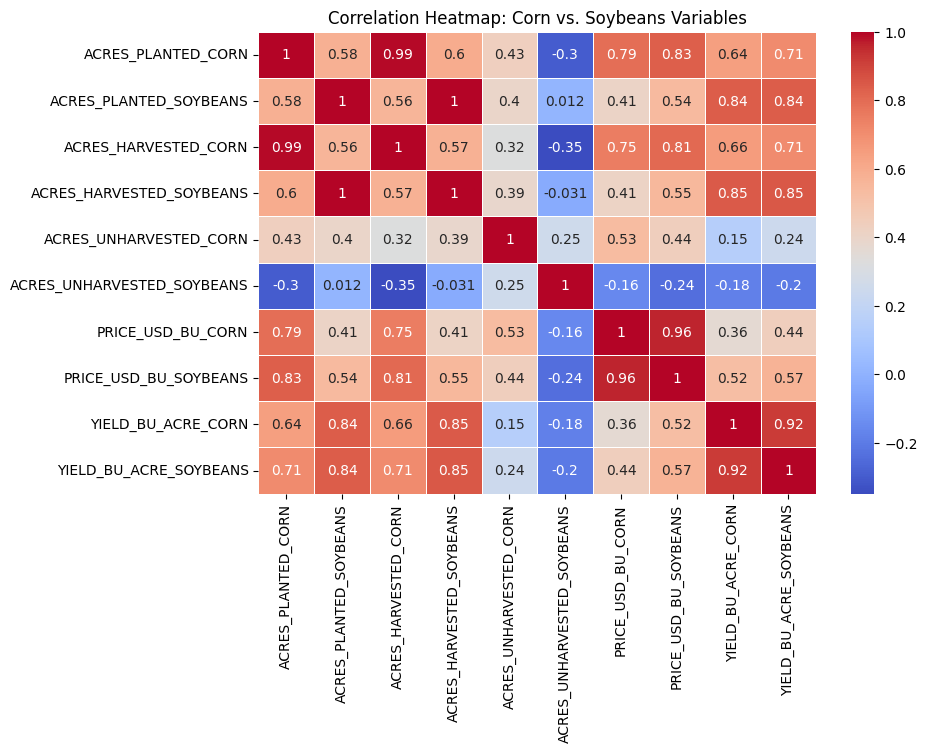

In [10]:
# prepare corn & soybean dataframe
corn_soybean_df = crop_df.copy()
corn_soybean_df.columns = corn_soybean_df.columns.str.replace(" ", "_").str.replace("/", "_")

# pivot the data to compare corn and soybeans side by side
df_pivot = corn_soybean_df.pivot(index="YEAR", columns="COMMODITY", values=["ACRES_PLANTED", "ACRES_HARVESTED", "ACRES_UNHARVESTED", "PRICE_USD_BU", "YIELD_BU_ACRE"])

# flatten multi-level column names
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns]

# compute correlation matrix
correlation_matrix = df_pivot.corr()

# plot combined heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap: Corn vs. Soybeans Variables")
plt.show()

Key takeaways:

*   Corn acres planted and harvested are highly correlated (~0.99), while soybean acres show an almost perfect correlation (~1), indicating that acreage follows similar planting and harvesting patterns for both crops.
*   Corn and soybean prices also show a strong correlation (~0.96), suggesting that market prices for these crops tend to move together.
*   Acres unharvested (soybeans) has a negative correlation with most variables, ranging from -0.16 to -0.35. This suggests a weak to moderate inverse relationship, meaning that as unharvested soybean acreage increases, other variables (such as yield and price) tend to decrease slightly, though the effect is not highly significant.
*   Corn and soybean yields exhibit a strong positive correlation (~0.98), indicating that their productivity trends are closely linked.

Next, heatmaps will be used to examine the correlations between variables within each crop—corn and soybeans.

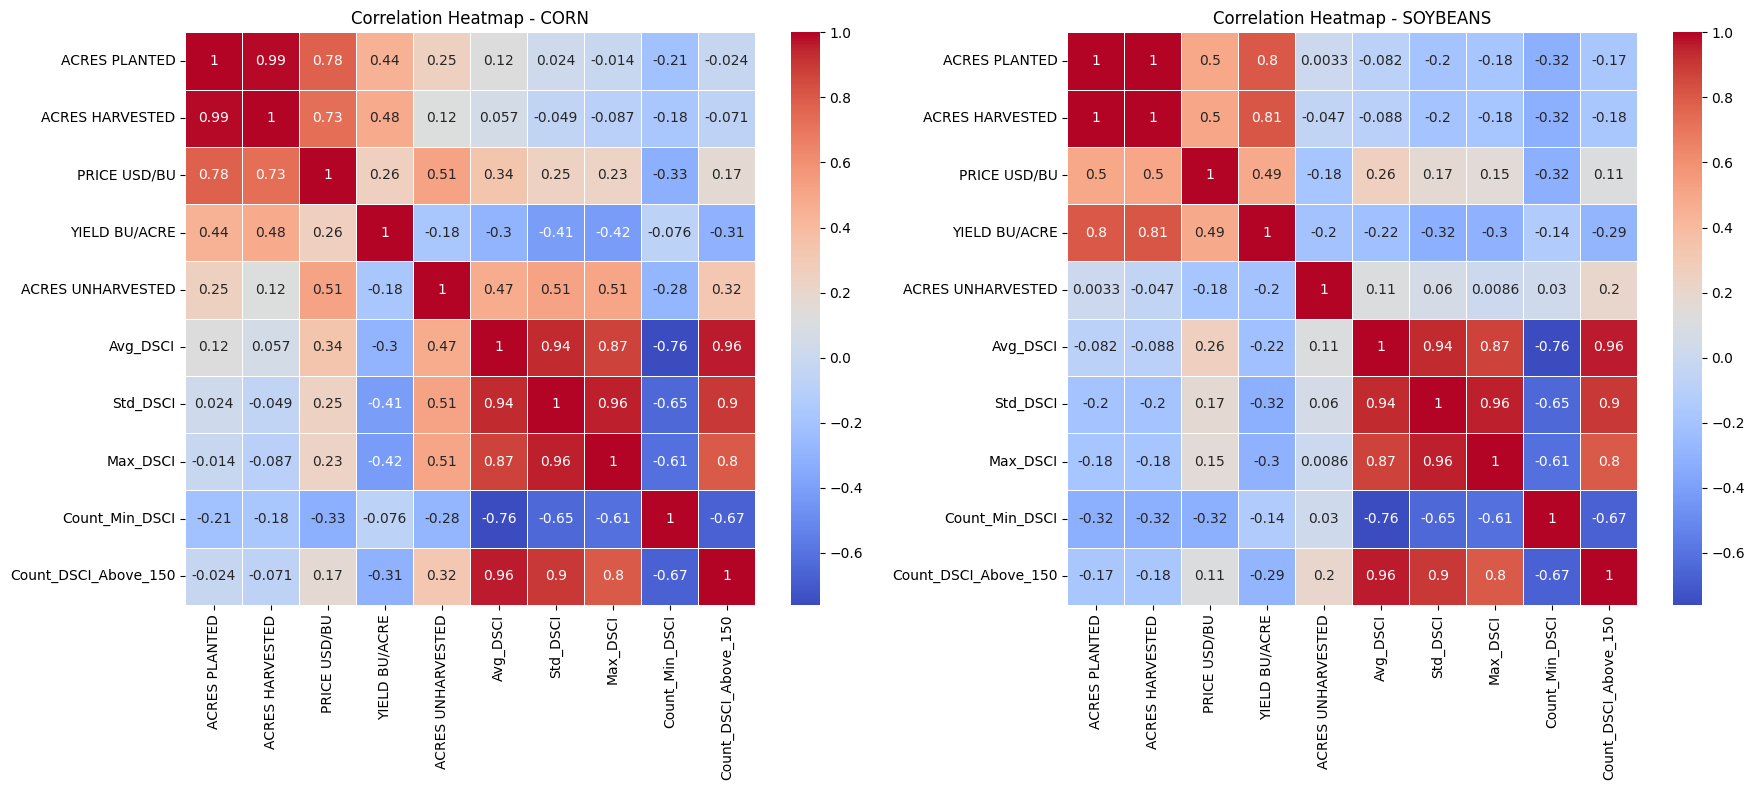

In [11]:
# define the crops
crops = ["CORN", "SOYBEANS"]#, "WHEAT"]

# create subplots for each crop
fig, axes = plt.subplots(1, len(crops), figsize=(18, 8))

for i, crop in enumerate(crops):
    # filter data for the current crop
    crop_heat_df = crop_drought_df[crop_drought_df["COMMODITY"] == crop].drop(columns=["COMMODITY", "YEAR"])#, "Std_DSCI"])
    
    # compute correlation matrix
    correlation = crop_heat_df.corr(numeric_only=True)

    # plot heatmap
    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5, ax=axes[i])

    # set title for each crop
    axes[i].set_title(f'Correlation Heatmap - {crop}')

plt.tight_layout()
plt.show()


#### Key takeaways:

Corn Correlation Heatmap:

*   Acres planted & price: 0.78 – This suggests a moderate to strong positive correlation. However, this does not necessarily mean that planting more corn leads to higher prices. In most cases, increased supply tends to lower prices due to market equilibrium. The positive correlation could instead indicate that farmers plant more acres when market prices are expected to be higher, possibly due to forecasts or past trends.
*   Acres harvested & yield: 0.48, and acres planted & yield: 0.44 – These indicate moderate positive correlations. While planting more acres may lead to higher total production, it does not necessarily mean that yield (measured per acre) increases. Factors such as soil quality, weather conditions, and input use (fertilizers, irrigation) play a critical role in yield outcomes.
*   Average DSCI & price: 0.51, and average DSCI & yield: -0.30 – A positive correlation between DSCI and price suggests that higher drought severity is associated with increased crop prices, likely due to reduced supply and market-driven price adjustments. The negative correlation between DSCI and yield implies that as drought severity increases, corn yields tend to decline, which aligns with expectations as drought stress limits plant growth.

Soybean Correlation Heatmap:

*   Acres planted & price: 0.50 – A moderate positive correlation, which might indicate that farmers adjust soybean planting decisions based on expected price trends. However, as with corn, an increase in planted acreage does not directly cause prices to rise.
*   Acres harvested & yield: 0.81, and acres planted & yield: 0.80 – These strong positive correlations suggest that for soybeans, higher planting and harvesting levels are more directly linked to higher yield compared to corn. This could be due to better drought resilience or more efficient resource use in soybean farming.
*   Average DSCI & price: 0.26, and average DSCI & yield: -0.22 – The weaker correlations indicate that drought has a less pronounced effect on soybean prices and yields compared to corn. While the negative correlation with yield suggests that drought still reduces soybean productivity, the effect is milder. The low positive correlation with price (0.26) implies that soybean prices may rise under drought conditions, but the impact is not as strong as with corn.

General Observations:

*   Corn and soybean variables exhibit similar correlation patterns, with some variation in strength.
*   DSCI negatively correlates with yield (-0.22 to -0.42) and positively correlates with price (0.17 to 0.34).

Interpretation:

*   The negative correlation with yield suggests that higher drought severity (DSCI) reduces crop productivity. This aligns with expectations, as drought stress limits water availability and plant growth.
*   The positive correlation with price indicates that when drought severity increases, reduced crop supply leads to higher market prices. This effect is more pronounced in corn than in soybeans.
*   Is this significant? While correlations provide insights into relationships, they do not establish causation. Further statistical testing, such as hypothesis testing (t-tests, Mann-Whitney U test) or regression analysis, is required to determine the strength and reliability of these relationships.

#### Next, the data will be explored using line plots, boxen plots, histograms, and KDE plots to analyze trends, distributions, and variability.

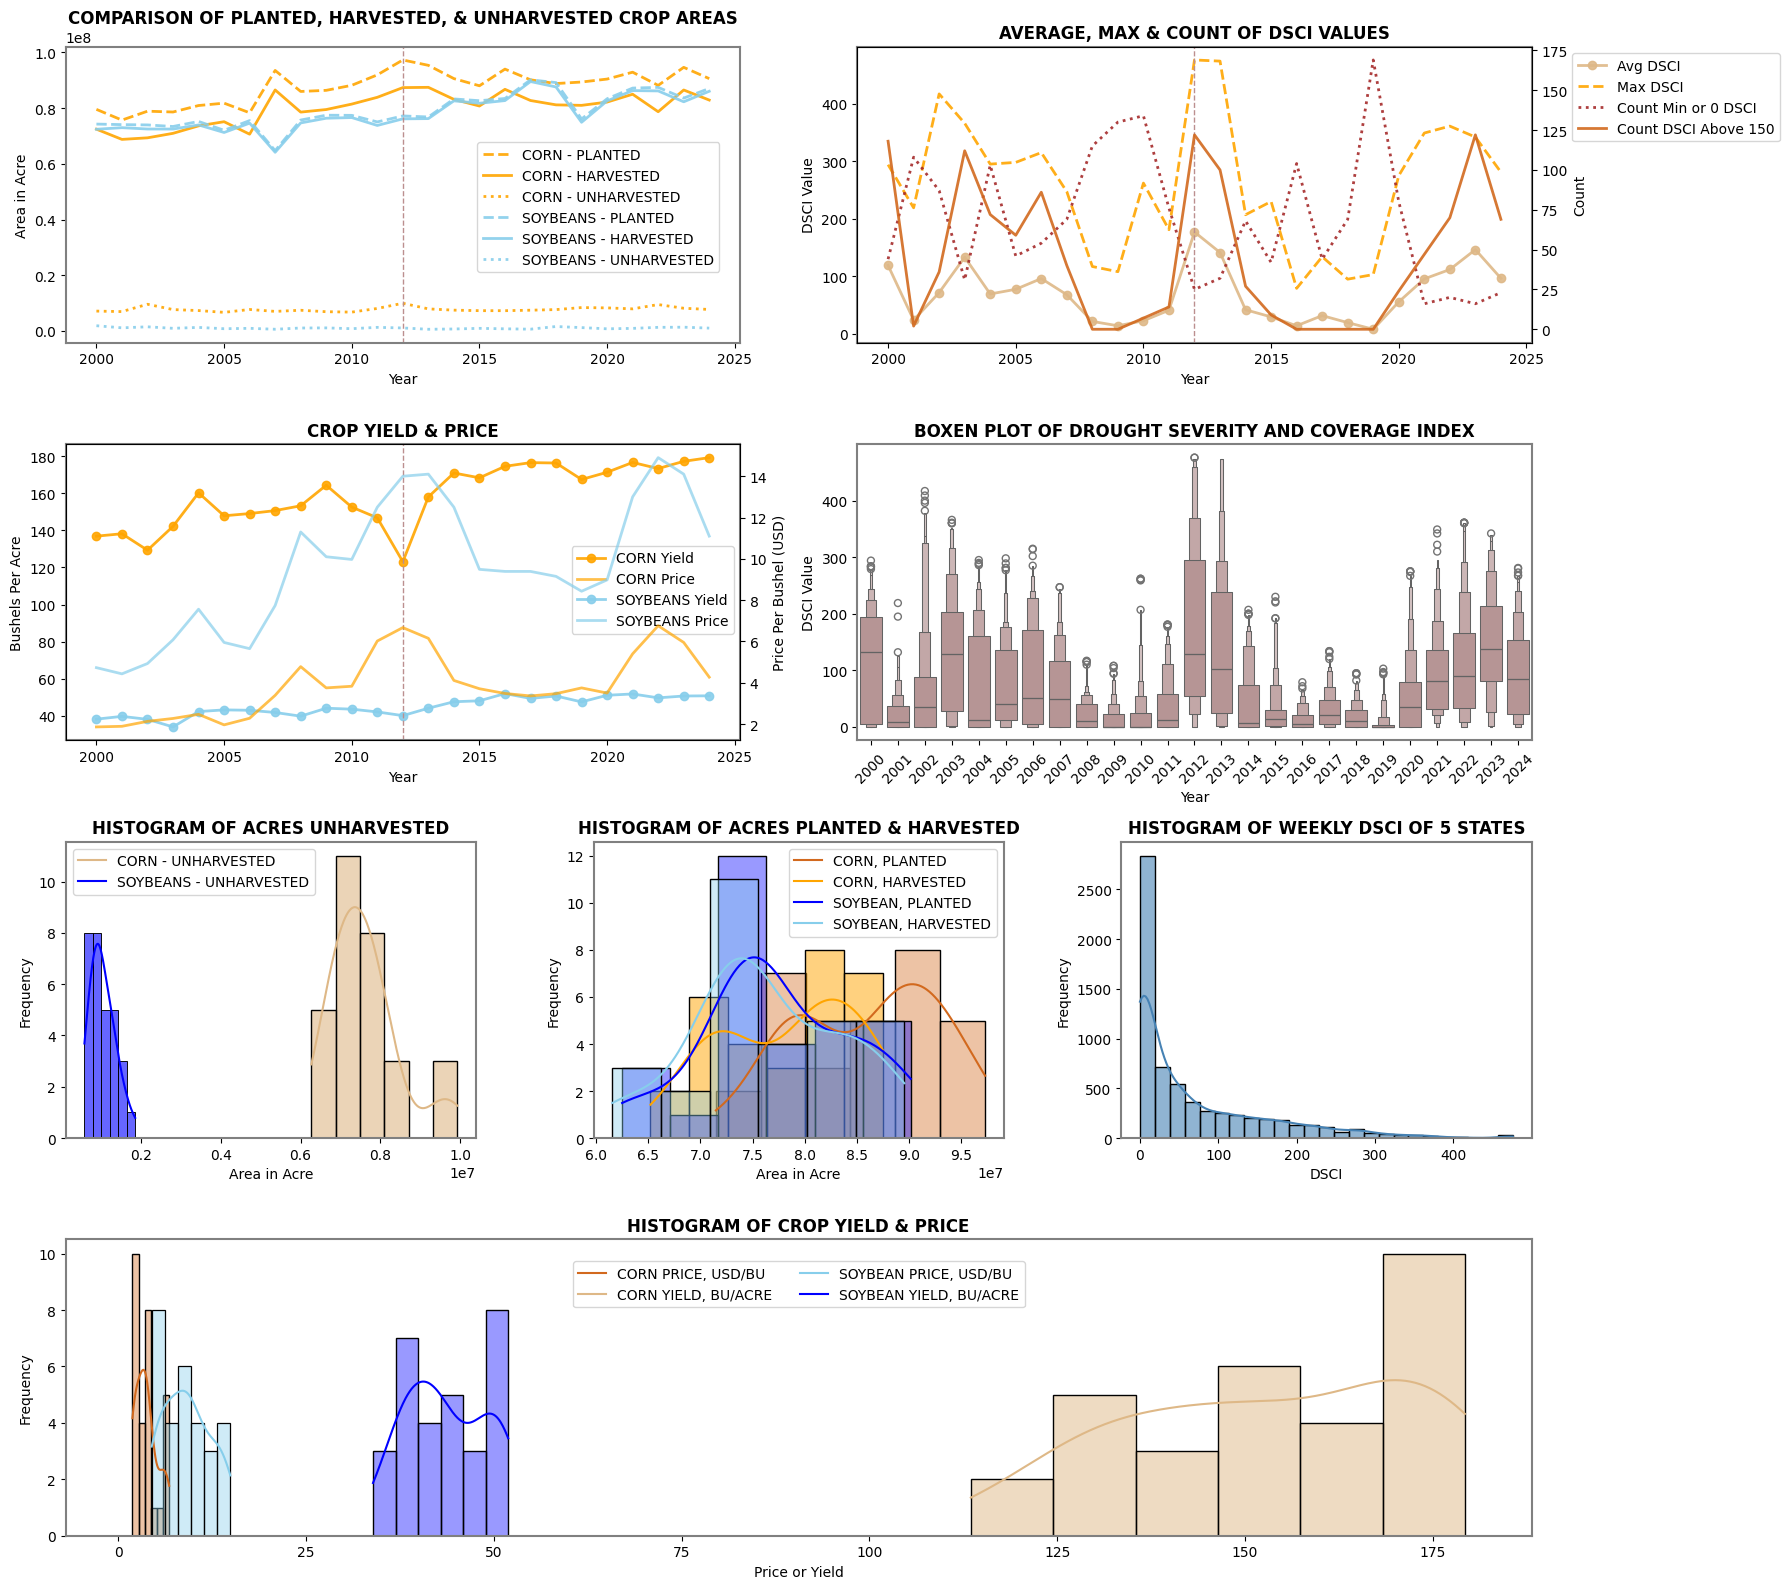

In [12]:
# initialize
fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(4, 6, figure=fig)

# function to add border to an axis
def add_gray_border(ax):
    for spine in ax.spines.values():
        spine.set_visible(True)       # spine is visible
        spine.set_color('gray')       # color for border
        spine.set_linewidth(1.5)      # width of the border

#--------------

# create one axis for all plots
ax1 = fig.add_subplot(gs[0:1, 0:3])

# define colors for each commodity
colors = {"CORN": "orange", "SOYBEANS": "skyblue"}#, "WHEAT": "chocolate"}

for commodity, color in colors.items():
    # filter data for the commodity
    subset = crop_drought_df[crop_drought_df["COMMODITY"] == commodity]
    
    # plot 'ACRES PLANTED' with a solid line
    sns.lineplot(
        x=subset["YEAR"], 
        y=subset["ACRES PLANTED"], 
        color=color, 
        linestyle='--', 
        alpha=0.9, 
        linewidth=2, 
        label=f'{commodity} - PLANTED', 
        ax=ax1
    )
    
    # plot 'ACRES HARVESTED' with a dashed line
    sns.lineplot(
        x=subset["YEAR"], 
        y=subset["ACRES HARVESTED"], 
        color=color, 
        linestyle='-', 
        alpha=0.9, 
        linewidth=2, 
        label=f'{commodity} - HARVESTED', 
        ax=ax1    
    )

    # plot 'ACRES UNHARVESTED' with a dotted line
    sns.lineplot(
        x=subset["YEAR"], 
        y=subset["ACRES UNHARVESTED"], 
        color=color, 
        linestyle=':', 
        alpha=0.9, 
        linewidth=2, 
        label=f'{commodity} - UNHARVESTED', 
        ax=ax1    
    )
# add vertical line at year 2012
ax1.axvline(x=2012, color='rosybrown', linestyle='--', linewidth=1)

ax1.set_xlabel('Year')
ax1.set_ylabel('Area in Acre')

# move the legend outside the plot
ax1.legend(loc="upper left", bbox_to_anchor=(.6, .7), fontsize=10, frameon=True)

# --------------------------------

ax2 = fig.add_subplot(gs[1:2, 0:3])

# create secondary y-axis for price per bushel
ax2_right = ax2.twinx()

# store legend handles and labels
handles = []
labels = []

for commodity, color in colors.items():
    # filter data for the commodity
    subset = crop_drought_df[crop_drought_df["COMMODITY"] == commodity]
    
    # plot bushels per acre (left y-axis)
    line1, = ax2.plot(
        subset["YEAR"], 
        subset["YIELD BU/ACRE"],
        color=color, 
        linestyle='-', 
        marker='o',
        alpha=0.9, 
        linewidth=2, 
        label=f'{commodity} Yield'
    )

    # plot price per bushel (right y-axis)
    line2, = ax2_right.plot(
        subset["YEAR"], 
        subset["PRICE USD/BU"], 
        color=color, 
        linestyle='-',
        alpha=0.7, 
        linewidth=2, 
        label=f'{commodity} Price'
    )

    # store handles and labels
    handles.extend([line1, line2])
    labels.extend([f'{commodity} Yield', f'{commodity} Price'])

# add vertical line at year 2012
ax2.axvline(x=2012, color='rosybrown', linestyle='--', linewidth=1)

# set labels
ax2.set_xlabel('Year')
ax2.set_ylabel('Bushels Per Acre')
ax2_right.set_ylabel('Price Per Bushel (USD)')

# adjust the legend position to avoid overlapping with the y-axis
ax2.legend(handles, labels, loc="upper left", bbox_to_anchor=(.74, .68), fontsize=10, frameon=True)

# ---------------------------------------------


# define subplot
ax3 = fig.add_subplot(gs[0:1, 3:6])
ax3_right = ax3.twinx()  # create secondary y-axis

# store legend handles and labels
handles = []
labels = []

# filter data for CORN. CORN & SOYBEANS have the same DSCI
subset3 = crop_drought_df[crop_drought_df["COMMODITY"] == 'CORN']

# plot Avg DSCI on the left y-axis
line1, = ax3.plot(
    subset3["YEAR"], subset3["Avg_DSCI"],
    color='burlywood', linestyle='-', marker='o', alpha=0.9, linewidth=2, label='Avg DSCI'
)
handles.append(line1)
labels.append('Avg DSCI')

# plot Max DSCI on the left y-axis
line2, = ax3.plot(
    subset3["YEAR"], subset3["Max_DSCI"],
    color='orange', linestyle='--', alpha=0.9, linewidth=2, label='Max DSCI'
)
handles.append(line2)
labels.append('Max DSCI')

# plot Count Min DSCI on the right y-axis
line3, = ax3_right.plot(
    subset3["YEAR"], subset3["Count_Min_DSCI"],
    color='brown', linestyle=':', alpha=0.9, linewidth=2, label='Count Min or 0 DSCI'
)
handles.append(line3)
labels.append('Count Min or 0 DSCI')

# plot Count_DSCI_Above_150 on the right y-axis
line4, = ax3_right.plot(
    subset3["YEAR"], subset3["Count_DSCI_Above_150"],
    color='chocolate', linestyle='-', alpha=0.9, linewidth=2, label='Count DSCI Above 150'
)
handles.append(line4)
labels.append('Count DSCI Above 150')

# add vertical line at year 2012
ax3.axvline(x=2012, color='rosybrown', linestyle='--', linewidth=1)

# set labels
ax3.set_xlabel('Year')
ax3.set_ylabel('DSCI Value')
ax3_right.set_ylabel('Count')

# combine all handles into one legend
ax3.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True)

# ------------------------------------

# boxen of close & open price difference

ax4 = fig.add_subplot(gs[1:2, 3:6])
sns.boxenplot(data=dsci_df, x='Year', y='DSCI', color='rosybrown', ax=ax4)
ax4.tick_params(axis='x', rotation=45)
ax4.set_ylabel('DSCI Value')

# ----------------------------------------------------------

# filter for corn and soybean year range 1926-2024
corn_df = crop_df[(crop_df["COMMODITY"] == "CORN") & (crop_df["YEAR"].between(1926, 2024))]
soybean_df = crop_df[(crop_df["COMMODITY"] == "SOYBEANS") & (crop_df["YEAR"].between(1926, 2024))]


# histogram of crop acreage, unharvested

ax5 = fig.add_subplot(gs[2:3, 0:2])
sns.histplot(corn_df['ACRES UNHARVESTED'], bins='sqrt', kde=True, ax=ax5, color='burlywood', alpha=.6)
sns.histplot(soybean_df['ACRES UNHARVESTED'], bins='sqrt', kde=True, ax=ax5, color='blue', alpha=.6)

# set labels
ax5.set_xlabel('Area in Acre')
ax5.set_ylabel('Frequency')

# move legend outside the plot
ax5.legend(('CORN - UNHARVESTED', 'SOYBEANS - UNHARVESTED'), loc='upper left')


# histogram of crop acreage, planted & harvested

ax6 = fig.add_subplot(gs[2:3, 2:4])
sns.histplot(corn_df['ACRES PLANTED'], bins='sqrt', kde=True, ax=ax6, color='chocolate', alpha=.4)
sns.histplot(corn_df['ACRES HARVESTED'], bins='sqrt', kde=True, ax=ax6, color='orange', alpha=.5)
sns.histplot(soybean_df['ACRES PLANTED'], bins='sqrt', kde=True, ax=ax6, color='blue', alpha=.4)
sns.histplot(soybean_df['ACRES HARVESTED'], bins='sqrt', kde=True, ax=ax6, color='skyblue', alpha=.4)

# set labels
ax6.set_xlabel('Area in Acre')
ax6.set_ylabel('Frequency')

# move legend outside the plot
ax6.legend(('CORN, PLANTED', 'CORN, HARVESTED', 'SOYBEAN, PLANTED', 'SOYBEAN, HARVESTED'), loc='upper right')

# --------------------------------------------------------------------

# histogram of DSCI
ax7 = fig.add_subplot(gs[2:3, 4:6])
sns.histplot(dsci_df['DSCI'], bins=25, kde=True, ax=ax7, color='steelblue', alpha=.6)

# set labels
ax7.set_xlabel('DSCI')
ax7.set_ylabel('Frequency')

# ------------------------------------------

# histogram of price and yield
ax8 = fig.add_subplot(gs[3:4, 0:6])
sns.histplot(corn_df['PRICE USD/BU'], bins='sqrt', kde=True, ax=ax8, color='chocolate', alpha=.4)
sns.histplot(corn_df['YIELD BU/ACRE'], bins='sqrt', kde=True, ax=ax8, color='burlywood', alpha=.5)
sns.histplot(soybean_df['PRICE USD/BU'], bins='sqrt', kde=True, ax=ax8, color='skyblue', alpha=.4)
sns.histplot(soybean_df['YIELD BU/ACRE'], bins='sqrt', kde=True, ax=ax8, color='blue', alpha=.4)

# set labels
ax8.set_xlabel('Price or Yield')
ax8.set_ylabel('Frequency')

# move legend outside the plot
ax8.legend(
    ('CORN PRICE, USD/BU', 'CORN YIELD, BU/ACRE', 'SOYBEAN PRICE, USD/BU', 'SOYBEAN YIELD, BU/ACRE'),
    loc='upper center',
    bbox_to_anchor=(0.5, .95), 
    ncol=2
)


# ---------------------------------------

# list of axes and titles
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
titles = [
    'COMPARISON OF PLANTED, HARVESTED, & UNHARVESTED CROP AREAS',
    'CROP YIELD & PRICE',
    'AVERAGE, MAX & COUNT OF DSCI VALUES',
    'BOXEN PLOT OF DROUGHT SEVERITY AND COVERAGE INDEX',
    'HISTOGRAM OF ACRES UNHARVESTED',
    'HISTOGRAM OF ACRES PLANTED & HARVESTED',
    'HISTOGRAM OF WEEKLY DSCI OF 5 STATES',
    'HISTOGRAM OF CROP YIELD & PRICE'
]

# set titles and labels
for ax, title in zip(axes, titles):
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(ax.get_xlabel(), fontweight='normal')  # Ensure normal weight for xlabel
    ax.set_ylabel(ax.get_ylabel(), fontweight='normal')  # Ensure normal weight for ylabel

# add border to all axes
for i in axes:
    add_gray_border(i)

plt.tight_layout()
plt.show()


#### Key takeaways:

Acres Planted and Harvested:

*   The scatter plots with line connections show that acres planted and harvested are closely related for both corn and soybeans.
*   The KDE and histogram plots for corn planted and harvested acres have similar curve shapes, indicating similar distributions. The same pattern is observed for soybeans.
*   However, the distributions are not normal
    *   A non-normal distribution suggests that the data is skewed, meaning extreme values (such as unusually high or low acreage in certain years) may be affecting the shape.
    *   This could indicate external influencing factors, such as climate conditions, market demand, or government policies affecting planting and harvesting decisions.

Price and Yield Relationship:

*   The scatter plots with line connections for corn and soybean price vs. yield show an inverse relationship—when price is high, yield is low, and vice versa.
*   This trend is particularly obvious in 2012, when yield was low, and prices were high.
    *   The drought plot shows that 2012 had the highest maximum DSCI, highest average DSCI, and the highest count of DSCI values above the threshold.
    *   This suggests that the severe drought in 2012 significantly reduced yield, leading to lower supply and consequently higher prices.
*   Non-normal distribution of price and yield:
    *   The KDE and histogram plots confirm that price and yield do not follow a normal distribution.
    *   This could be due to market shocks (e.g., droughts, policy changes, trade disruptions) or natural constraints on crop production.

Drought Severity Distribution:

*   The boxen plot indicates that in most years, drought severity remains relatively low, with fewer instances of extreme drought.
*   The overall histogram of DSCI values supports this, showing that most drought severity values are close to 0 or below 100, meaning extreme drought conditions are rare.
*   KDE plot interpretation:
    *   The KDE plot shows that DSCI is not normally distributed.
    *   The histogram has a high frequency of lower values that gradually taper down toward the maximum values, resembling a gamma distribution rather than a normal distribution.
        *   A gamma-like distribution suggests that low drought severity is the most common, while extreme drought events are rare but impactful.
        *   This makes sense, as most years experience mild or no drought, with only a few experiencing severe conditions.

## STEP 4: FEATURE ENGINEERING

Feature engineering will be applied to create interaction features that account for the impact of drought on crop prices and yields. Specifically, adjusted price and yield will be calculated and visualized using heatmaps, line plots, histograms, and KDE plots.

Adjusted Features:

*   Price per Bushel Adjusted by Drought: 
$$ \text{Adj\_Price} = \frac{\text{PRICE (USD/BU)}}{\text{Avg\_DSCI}} $$

*   Yield Adjusted for Drought: 
$$ \text{Adj\_Yield} = \frac{\text{YIELD (BU/ACRE)}}{\text{Avg\_DSCI}} $$

Purpose of This Transformation:
*   Normalizes price and yield values based on drought severity.
*   Helps assess whether higher drought severity systematically influences yield and price adjustments.
*   Allows for better interpretation of how drought conditions impact overall crop productivity and market dynamics.


In [13]:
# create adjusted price and adjusted yield
crop_drought_df["Adj_Price"] = crop_drought_df["PRICE USD/BU"] / crop_drought_df["Avg_DSCI"]
crop_drought_df["Adj_Yield"] = crop_drought_df["YIELD BU/ACRE"] / crop_drought_df["Avg_DSCI"]

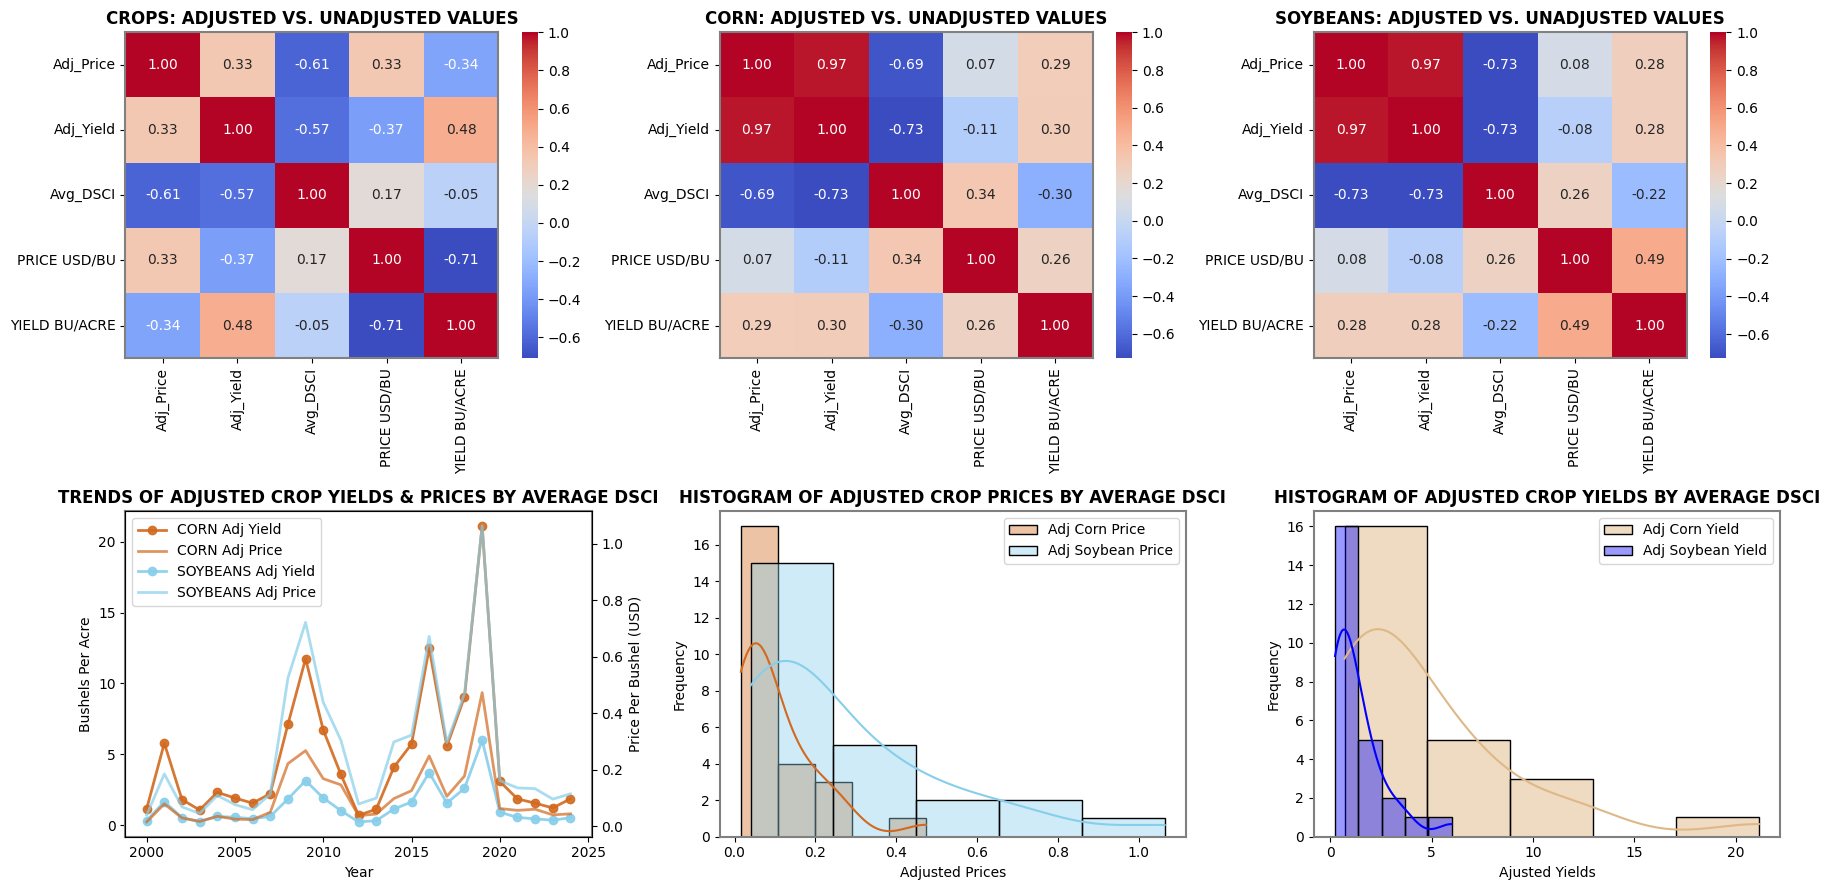

In [14]:
# define figure size
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 3, figure=fig)

# function to add border to an axis
def add_gray_border(ax):
    for spine in ax.spines.values():
        spine.set_visible(True)       # make spine visible
        spine.set_color('gray')       # set border color
        spine.set_linewidth(1.5)      # set border width

# filter for corn and soybeans separately
corn_df = crop_drought_df[crop_drought_df["COMMODITY"] == "CORN"]
soybean_df = crop_drought_df[crop_drought_df["COMMODITY"] == "SOYBEANS"]

# define color scheme for commodities
colors = {"CORN": "chocolate", "SOYBEANS": "skyblue"}

# -----------------------------------
# create correlation heatmap
ax9 = fig.add_subplot(gs[0, 0])

# compute correlation matrix
corr_matrix = crop_drought_df[['Adj_Price', 'Adj_Yield', 'Avg_DSCI', 'PRICE USD/BU', 'YIELD BU/ACRE']].corr()

# plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax9)

# -----------------------------------
# create corn correlation heatmap
ax10 = fig.add_subplot(gs[0, 1])

# compute correlation matrix
corr_matrix = corn_df[['Adj_Price', 'Adj_Yield', 'Avg_DSCI', 'PRICE USD/BU', 'YIELD BU/ACRE']].corr()

# plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax10)

# -----------------------------------
# create corn correlation heatmap
ax11 = fig.add_subplot(gs[0, 2])

# compute correlation matrix
corr_matrix = soybean_df[['Adj_Price', 'Adj_Yield', 'Avg_DSCI', 'PRICE USD/BU', 'YIELD BU/ACRE']].corr()

# plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax11)

# -----------------------------------
# create first subplot for adjusted yield and price trends
ax12 = fig.add_subplot(gs[1, 0])

# create secondary y-axis for price per bushel
ax12_right = ax12.twinx()

# store legend handles and labels
handles = []
labels = []


for commodity, color in colors.items():
    # filter data for the commodity
    subset = crop_drought_df[crop_drought_df["COMMODITY"] == commodity]
    
    # plot bushels per acre (left y-axis)
    line1, = ax12.plot(
        subset["YEAR"], 
        subset["Adj_Yield"],
        color=color, 
        linestyle='-', 
        marker='o',
        alpha=0.9, 
        linewidth=2, 
        label=f'{commodity} Adj Yield'
    )

    # plot price per bushel (right y-axis)
    line2, = ax12_right.plot(
        subset["YEAR"], 
        subset["Adj_Price"], 
        color=color, 
        linestyle='-',
        alpha=0.7, 
        linewidth=2, 
        label=f'{commodity} Adj Price'
    )

    # store handles and labels
    handles.extend([line1, line2])
    labels.extend([f'{commodity} Adj Yield', f'{commodity} Adj Price'])

# set labels
ax12.set_xlabel('Year')
ax12.set_ylabel('Bushels Per Acre')
ax12_right.set_ylabel('Price Per Bushel (USD)')

# adjust the legend position
ax12.legend(handles, labels, loc="upper left", fontsize=10, frameon=True)

# ------------------------------------------
# create third subplot for histograms of adjusted prices
ax13 = fig.add_subplot(gs[1, 1])

# plot histograms
sns.histplot(corn_df['Adj_Price'], bins='sqrt', kde=True, ax=ax13, color='chocolate', alpha=.4, label='Adj Corn Price')
sns.histplot(soybean_df['Adj_Price'], bins='sqrt', kde=True, ax=ax13, color='skyblue', alpha=.4, label='Adj Soybean Price')

# set labels
ax13.set_xlabel('Adjusted Prices')
ax13.set_ylabel('Frequency')

# move legend outside the plot
ax13.legend(loc='upper right', ncol=1, frameon=True)

# ----------------------------

# create third subplot for histograms of adjusted yields
ax14 = fig.add_subplot(gs[1, 2])

# plot histograms
sns.histplot(corn_df['Adj_Yield'], bins='sqrt', kde=True, ax=ax14, color='burlywood', alpha=.5, label='Adj Corn Yield')
sns.histplot(soybean_df['Adj_Yield'], bins='sqrt', kde=True, ax=ax14, color='blue', alpha=.4, label='Adj Soybean Yield')

# set labels
ax14.set_xlabel('Ajusted Yields')
ax14.set_ylabel('Frequency')

# move legend outside the plot
ax14.legend(loc='upper right', ncol=1, frameon=True)


# ---------------------------------------
# list of axes and titles
axes = [ax9, ax10, ax11, ax12, ax13, ax14]
titles = [
    'CROPS: ADJUSTED VS. UNADJUSTED VALUES',
    'CORN: ADJUSTED VS. UNADJUSTED VALUES',
    'SOYBEANS: ADJUSTED VS. UNADJUSTED VALUES',
    'TRENDS OF ADJUSTED CROP YIELDS & PRICES BY AVERAGE DSCI',
    'HISTOGRAM OF ADJUSTED CROP PRICES BY AVERAGE DSCI',
    'HISTOGRAM OF ADJUSTED CROP YIELDS BY AVERAGE DSCI'
]

# set titles and labels
for ax, title in zip(axes, titles):
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(ax.get_xlabel(), fontweight='normal')  # Ensure normal weight for xlabel
    ax.set_ylabel(ax.get_ylabel(), fontweight='normal')  # Ensure normal weight for ylabel

# add border to all axes
for i in axes:
    add_gray_border(i)

# adjust layout
plt.tight_layout()
plt.show()


#### Key takeaways:

Heatmap Analysis
*   Overall correlations (both crops combined):
    *   Adjusted price and yield show stronger negative correlations with drought severity (DSCI) than their non-adjusted counterparts.
    *   The correlation stronger when adjusted because
        *   Non-adjusted price and yield values do not directly account for drought severity, making their relationships weaker.
        *   Adjusted values normalize for drought impact, revealing a clearer negative relationship: as drought severity increases, both adjusted price and adjusted yield decrease more significantly.
    *   The positive correlation (0.33) between adjusted price and adjusted yield suggests that, after accounting for drought, years with higher yield tend to have slightly higher prices.
*   Corn and soybean specific correlations:
    *   Correlations are stronger when analyzing each crop separately.
        *   When both crops are combined, additional variability is introduced (e.g., different market behaviors, planting practices, and drought resilience levels).
        *   Analyzing each crop individually eliminates these variations, resulting in stronger correlations.
    *   Adjusted Price vs. Adjusted Yield (0.97) are strong for individual crops.
        *   This suggests that, after accounting for drought, price and yield move almost proportionally for each crop.
        *   When drought reduces yield, adjusted prices tend to reflect this shortage more directly within the same crop.
*   Overall Pattern:
    *   Drought severity (DSCI) has a stronger negative correlation with price and yield when adjusted, especially within each crop.
    *   Adjusted price and adjusted yield are highly correlated within individual crops, meaning their relationship is more consistent when the drought factor is accounted for.

KDE and Histogram Plots
*   The KDE and histogram plots align with the findings from the heatmaps, confirming the relationships observed.
*   The distributions of adjusted price and adjusted yield for corn closely resemble each other, indicating that both variables are affected in a similar manner by drought severity.
*   The same pattern is observed for soybeans, where adjusted price and adjusted yield follow a nearly identical distribution.
*   For both corn and soybeans, the distributions appear to follow a gamma distribution rather than a normal distribution.
    *   A gamma distribution suggests that values are skewed, meaning lower values are more frequent, while extreme values occur less often but are still possible.
    *   This aligns with the nature of agricultural data--most years have moderate price and yield values, while extreme conditions (such as severe drought or exceptionally high yields) occur less frequently.

## STEP 5: EXPLORATORY DATA ANALYSIS (EDA)

#### Statistical Test

To assess whether drought severity (DSCI) impacts crop yield and price, two statistical tests will be performed:

*   T-test (parametric)
*   Mann-Whitney U test (non-parametric)

These tests compare the means or distributions of two independent groups:

*   Low drought years
*   High drought years

The normality assumption applies to the dependent variable (Yield or Price) within each group. The choice of test depends on whether the normality and variance assumptions are met.

Testing Procedure:

1. Defining High and Low Drought Groups

    The dataset is split into high drought and low drought years based on the median Avg_DSCI for corn and soybeans.

2. Checking Normality and Variance Assumptions

    Normality Test (Shapiro-Wilk Test)

*   If p > 0.05, data follows a normal distribution.
*   If p < 0.05, data is not normal, and the Mann-Whitney U test will be used instead of a t-test.

    Equal Variance Test (Levene's Test)

*   If p > 0.05, variance is equal, t-test will be used.
*   If p < 0.05, variance is unequal, Welch’s t-test will be used.

3. Performing the Appropriate Test

*   If both groups are normally distributed, t-test (or Welch’s t-test for unequal variance) is used.
*   If at least one group is not normal, Mann-Whitney U test is used.

4. Interpreting the Results

    P-value from the selected test:

*   If p < 0.05, reject the null hypothesis; drought significantly affects yield or price.
*   If p > 0.05, fail to reject the null hypothesis, no strong statistical evidence that drought affects yield or price.

#### First, statistical tests will be conducted on the non-adjusted prices and yields of corn and soybeans.

In [15]:
# filter Corn and Soybeans separately
corn_df = crop_drought_df[crop_drought_df["COMMODITY"] == "CORN"]
soybean_df = crop_drought_df[crop_drought_df["COMMODITY"] == "SOYBEANS"]

# define median split for drought conditions
median_drought = crop_drought_df["Avg_DSCI"].median()

# split into high and low drought groups
def split_drought(data, column):
    low_drought = data[data["Avg_DSCI"] <= median_drought][column].dropna()
    high_drought = data[data["Avg_DSCI"] > median_drought][column].dropna()
    return low_drought, high_drought

# apply to corn & soybeans for both price and yield
corn_price_low, corn_price_high = split_drought(corn_df, "PRICE USD/BU")
corn_yield_low, corn_yield_high = split_drought(corn_df, "YIELD BU/ACRE")
soybean_price_low, soybean_price_high = split_drought(soybean_df, "PRICE USD/BU")
soybean_yield_low, soybean_yield_high = split_drought(soybean_df, "YIELD BU/ACRE")

# function to perform tests
def run_tests(low_drought, high_drought, variable_name, commodity):
    # check normality
    shapiro_low = shapiro(low_drought)
    shapiro_high = shapiro(high_drought)

    # check variance equality
    levene_stat, levene_p = levene(low_drought, high_drought)

    # choose test
    if shapiro_low.pvalue > 0.05 and shapiro_high.pvalue > 0.05:
        if levene_p > 0.05:
            test_stat, test_p = ttest_ind(low_drought, high_drought, equal_var=True)
            test_type = "T-test (Equal Variance)"
        else:
            test_stat, test_p = ttest_ind(low_drought, high_drought, equal_var=False)
            test_type = "Welch's T-test (Unequal Variance)"
    else:
        test_stat, test_p = mannwhitneyu(low_drought, high_drought, alternative='two-sided')
        test_type = "Mann-Whitney U test (Non-parametric)"

    return {
        "Commodity": commodity,
        "Variable": variable_name,
        "Shapiro-Wilk Statistic (Low)": shapiro_low.statistic,
        "Shapiro-Wilk P-value (Low)": shapiro_low.pvalue,
        "Shapiro-Wilk Statistic (High)": shapiro_high.statistic,
        "Shapiro-Wilk P-value (High)": shapiro_high.pvalue,
        "Levene's Statistic": levene_stat,
        "Levene's P-value": levene_p,
        "Test Used": test_type,
        "Test Statistic": test_stat,
        "P-value": test_p
    }

# run tests for each case
results = []
results.append(run_tests(corn_price_low, corn_price_high, "PRICE USD/BU", "Corn"))
results.append(run_tests(corn_yield_low, corn_yield_high, "YIELD BU/ACRE", "Corn"))
results.append(run_tests(soybean_price_low, soybean_price_high, "PRICE USD/BU", "Soybeans"))
results.append(run_tests(soybean_yield_low, soybean_yield_high, "YIELD BU/ACRE", "Soybeans"))

# convert to DataFrame for easy visualization
results_df = pd.DataFrame(results)
display(results_df)


,Commodity,Variable,Shapiro-Wilk Statistic (Low),Shapiro-Wilk P-value (Low),Shapiro-Wilk Statistic (High),Shapiro-Wilk P-value (High),Levene's Statistic,Levene's P-value,Test Used,Test Statistic,P-value
0,Corn,PRICE USD/BU,0.852595,0.030808,0.818808,0.015453,15.266681,0.000708,Mann-Whitney U test (Non-parametric),77.000000,0.978299
1,Corn,YIELD BU/ACRE,0.903101,0.147495,0.931312,0.394224,2.950460,0.099290,T-test (Equal Variance),1.225294,0.232865
2,Soybeans,PRICE USD/BU,0.908565,0.175273,0.827141,0.019389,20.475441,0.000152,Mann-Whitney U test (Non-parametric),75.000000,0.891773
3,Soybeans,YIELD BU/ACRE,0.923945,0.283412,0.928913,0.368735,0.519535,0.478303,T-test (Equal Variance),1.043007,0.307785


As shown in the results DataFrame, all final test p-values are greater than 0.05, indicating that we fail to reject the null hypothesis. This suggests that, based on these tests, there is no strong statistical evidence that drought (DSCI) significantly affects the non-adjusted yield or price of corn or soybeans.

#### Next, statistical tests will be conducted on the adjusted prices and yields of corn and soybeans to determine whether there are significant differences compared to the previous test on non-adjusted values.

In [16]:
# apply to corn & soybeans for both adjusted price and yield
adj_corn_price_low, adj_corn_price_high = split_drought(corn_df, "Adj_Price")
adj_corn_yield_low, adj_corn_yield_high = split_drought(corn_df, "Adj_Yield")
adj_soybean_price_low, adj_soybean_price_high = split_drought(soybean_df, "Adj_Price")
adj_soybean_yield_low, adj_soybean_yield_high = split_drought(soybean_df, "Adj_Yield")

# function to perform tests
def run_tests(low_drought, high_drought, variable_name, commodity):
    # check normality
    shapiro_low = shapiro(low_drought)
    shapiro_high = shapiro(high_drought)

    # check variance equality
    levene_stat, levene_p = levene(low_drought, high_drought)

    # choose test
    if shapiro_low.pvalue > 0.05 and shapiro_high.pvalue > 0.05:
        if levene_p > 0.05:
            test_stat, test_p = ttest_ind(low_drought, high_drought, equal_var=True)
            test_type = "T-test (Equal Variance)"
        else:
            test_stat, test_p = ttest_ind(low_drought, high_drought, equal_var=False)
            test_type = "Welch's T-test (Unequal Variance)"
    else:
        test_stat, test_p = mannwhitneyu(low_drought, high_drought, alternative='two-sided')
        test_type = "Mann-Whitney U test (Non-parametric)"

    return {
        "Commodity": commodity,
        "Variable": variable_name,
        "Shapiro-Wilk Statistic (Low)": shapiro_low.statistic,
        "Shapiro-Wilk P-value (Low)": shapiro_low.pvalue,
        "Shapiro-Wilk Statistic (High)": shapiro_high.statistic,
        "Shapiro-Wilk P-value (High)": shapiro_high.pvalue,
        "Levene's Statistic": levene_stat,
        "Levene's P-value": levene_p,
        "Test Used": test_type,
        "Test Statistic": test_stat,
        "P-value": test_p
    }

# run tests for each case
results_adj = []
results_adj.append(run_tests(adj_corn_price_low, adj_corn_price_high, "Adjusted Price", "Corn"))
results_adj.append(run_tests(adj_corn_yield_low, adj_corn_yield_high, "Adjusted Yield", "Corn"))
results_adj.append(run_tests(adj_soybean_price_low, adj_soybean_price_high, "Adjusted Price", "Soybeans"))
results_adj.append(run_tests(adj_soybean_yield_low, adj_soybean_yield_high, "Adjusted Yield", "Soybeans"))

# convert to DataFrame for easy visualization
results_adj_df = pd.DataFrame(results_adj)
display(results_adj_df)


,Commodity,Variable,Shapiro-Wilk Statistic (Low),Shapiro-Wilk P-value (Low),Shapiro-Wilk Statistic (High),Shapiro-Wilk P-value (High),Levene's Statistic,Levene's P-value,Test Used,Test Statistic,P-value
0,Corn,Adjusted Price,0.862886,0.042059,0.960012,0.784003,8.156411,0.008940,Mann-Whitney U test (Non-parametric),154.000000,0.000040
1,Corn,Adjusted Yield,0.840786,0.021690,0.959192,0.772240,6.213888,0.020315,Mann-Whitney U test (Non-parametric),155.000000,0.000032
2,Soybeans,Adjusted Price,0.906035,0.161821,0.959913,0.782589,7.987685,0.009574,Welch's T-test (Unequal Variance),4.577963,0.000587
3,Soybeans,Adjusted Yield,0.836253,0.018993,0.924828,0.328494,5.995520,0.022385,Mann-Whitney U test (Non-parametric),156.000000,0.000025


All adjusted price and yield values show statistically significant differences between high and low drought years (p < 0.05 in all cases), indicating that drought has a significant impact when accounting for drought severity (DSCI).

Unlike the unadjusted values, adjusted price and yield exhibit clear differences across drought conditions, suggesting that DSCI plays a role in influencing price and yield when interaction effects are considered.

#### Multiple Regressions Analysis

Multiple regression analyses will be conducted on non-adjusted and adjusted prices and yields to identify additional factors influencing them. Since drought alone may not have a strong effect, interactions and other explanatory variables will be examined to better understand their impact.

Generally, multiple regression is used to test whether independent variables significantly predict the dependent variable.

Null Hypothesis (H0): None of the independent variables have a significant effect on the dependent variable (i.e., all coefficients are equal to zero).

Alternative Hypothesis (H0): At least one independent variable has a significant effect on the dependent variable.

1. Overall Model Significance (F-statistic & p-value)
*   If p < 0.05, H0 is rejected; at least one predictor significantly affects the dependent variable.
*   If p > 0.05, H0 is failed to be rejected; no strong evidence that the predictors explain variation in the dependent variable.

2. Individual Variable Significance (t-tests & p-values for each coefficient)
*   If p < 0.05, the variable significantly affects the dependent variable.
*   If p > 0.05, the variable does not contribute significantly to the model.

#### Multiple Regression Analysis on Non-Adjusted Prices and Yields

In [17]:
# rename columns to remove spaces
new_crop_drought_df = crop_drought_df.copy()
new_crop_drought_df = new_crop_drought_df.rename(columns={
    "ACRES PLANTED": "ACRES_PLANTED",
    "ACRES HARVESTED": "ACRES_HARVESTED",
    "PRICE USD/BU": "PRICE_USD_BU",
    "YIELD BU/ACRE": "YIELD_BU_ACRE"
})

# create interaction terms
new_crop_drought_df["Drought_Acreage_Interaction"] = new_crop_drought_df["Avg_DSCI"] * new_crop_drought_df["ACRES_PLANTED"]
new_crop_drought_df["Drought_MaxDSCI_Interaction"] = new_crop_drought_df["Avg_DSCI"] * new_crop_drought_df["Max_DSCI"]
new_crop_drought_df["Drought_Year_Interaction"] = new_crop_drought_df["Avg_DSCI"] * new_crop_drought_df["YEAR"]
new_crop_drought_df["Drought_Extreme_Interaction"] = new_crop_drought_df["Avg_DSCI"] * new_crop_drought_df["Count_DSCI_Above_150"]

# filter data for corn and soybeans separately
corn_df = new_crop_drought_df[new_crop_drought_df["COMMODITY"] == "CORN"]
soybean_df = new_crop_drought_df[new_crop_drought_df["COMMODITY"] == "SOYBEANS"]

# regression formulas (using Q() to handle column names with special characters)
formula_price = "Q('PRICE_USD_BU') ~ Q('Avg_DSCI') + Q('ACRES_PLANTED') + Q('Max_DSCI') + Q('YEAR') + Q('Count_DSCI_Above_150') + \
                Q('Drought_Acreage_Interaction') + Q('Drought_MaxDSCI_Interaction') + Q('Drought_Year_Interaction') + Q('Drought_Extreme_Interaction')"

formula_yield = "Q('YIELD_BU_ACRE') ~ Q('Avg_DSCI') + Q('ACRES_PLANTED') + Q('Max_DSCI') + Q('YEAR') + Q('Count_DSCI_Above_150') + \
                Q('Drought_Acreage_Interaction') + Q('Drought_MaxDSCI_Interaction') + Q('Drought_Year_Interaction') + Q('Drought_Extreme_Interaction')"

# run regression for corn
corn_price_interaction_model = smf.ols(formula_price, data=corn_df).fit()
corn_yield_interaction_model = smf.ols(formula_yield, data=corn_df).fit()

# run regression for soybeans
soybeans_price_interaction_model = smf.ols(formula_price, data=soybean_df).fit()
soybeans_yield_interaction_model = smf.ols(formula_yield, data=soybean_df).fit()


In [18]:
# print summaries
print("\nCorn Price Interaction Model:\n", corn_price_interaction_model.summary())


Corn Price Interaction Model:
                             OLS Regression Results                            
Dep. Variable:      Q('PRICE_USD_BU')   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     7.390
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           0.000404
Time:                        13:39:46   Log-Likelihood:                -24.484
No. Observations:                  25   AIC:                             68.97
Df Residuals:                      15   BIC:                             81.16
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [19]:
print("\nCorn Yield Interaction Model:\n", corn_yield_interaction_model.summary())


Corn Yield Interaction Model:
                             OLS Regression Results                            
Dep. Variable:     Q('YIELD_BU_ACRE')   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     12.71
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           1.61e-05
Time:                        13:39:46   Log-Likelihood:                -78.040
No. Observations:                  25   AIC:                             176.1
Df Residuals:                      15   BIC:                             188.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [20]:
print("\nSoybean Price Interaction Model:\n", soybeans_price_interaction_model.summary())


Soybean Price Interaction Model:
                             OLS Regression Results                            
Dep. Variable:      Q('PRICE_USD_BU')   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     4.589
Date:                Sun, 16 Mar 2025   Prob (F-statistic):            0.00474
Time:                        13:39:46   Log-Likelihood:                -47.475
No. Observations:                  25   AIC:                             114.9
Df Residuals:                      15   BIC:                             127.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [21]:
print("\nSoybean Yield Interaction Model:\n", soybeans_yield_interaction_model.summary())


Soybean Yield Interaction Model:
                             OLS Regression Results                            
Dep. Variable:     Q('YIELD_BU_ACRE')   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     19.83
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           8.94e-07
Time:                        13:39:46   Log-Likelihood:                -43.760
No. Observations:                  25   AIC:                             107.5
Df Residuals:                      15   BIC:                             119.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

##### Overall summary and key insights for multiple Regression analysis on non-adjusted prices and yields:
*   Drought significantly reduces corn price but does NOT affect soybean price.
*   Corn and soybean yield models suggest a weak relationship between drought (Avg_DSCI) and yields.
*   Surprisingly, extreme drought events (>150 DSCI) slightly increase yields for both crops.
*   Soybean prices appear to be more market-driven rather than drought-driven.
*   Multicollinearity is a concern in all models, which may affect interpretation of coefficients.

#### Multiple Regression Analysis on Adjusted Prices and Yields

In [22]:
# regression formulas (using Q() to handle column names with special characters)
formula_price = "Q('Adj_Price') ~ Q('Avg_DSCI') + Q('ACRES_PLANTED') + Q('Max_DSCI') + Q('YEAR') + Q('Count_DSCI_Above_150') + \
                Q('Drought_Acreage_Interaction') + Q('Drought_MaxDSCI_Interaction') + Q('Drought_Year_Interaction') + Q('Drought_Extreme_Interaction')"

formula_yield = "Q('Adj_Yield') ~ Q('Avg_DSCI') + Q('ACRES_PLANTED') + Q('Max_DSCI') + Q('YEAR') + Q('Count_DSCI_Above_150') + \
                Q('Drought_Acreage_Interaction') + Q('Drought_MaxDSCI_Interaction') + Q('Drought_Year_Interaction') + Q('Drought_Extreme_Interaction')"

# run regression for corn
corn_adj_price_interaction_model = smf.ols(formula_price, data=corn_df).fit()
corn_adj_yield_interaction_model = smf.ols(formula_yield, data=corn_df).fit()

# run regression for soybeans
soybeans_adj_price_interaction_model = smf.ols(formula_price, data=soybean_df).fit()
soybeans_adj_yield_interaction_model = smf.ols(formula_yield, data=soybean_df).fit()

In [23]:
print("\nCorn Ajusted Price Interaction Model:\n", corn_adj_price_interaction_model.summary())


Corn Ajusted Price Interaction Model:
                             OLS Regression Results                            
Dep. Variable:         Q('Adj_Price')   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     8.060
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           0.000248
Time:                        13:39:46   Log-Likelihood:                 43.030
No. Observations:                  25   AIC:                            -66.06
Df Residuals:                      15   BIC:                            -53.87
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [24]:
print("\nCorn Ajusted Yield Interaction Model:\n", corn_adj_yield_interaction_model.summary())


Corn Ajusted Yield Interaction Model:
                             OLS Regression Results                            
Dep. Variable:         Q('Adj_Yield')   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     10.65
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           4.80e-05
Time:                        13:39:46   Log-Likelihood:                -49.059
No. Observations:                  25   AIC:                             118.1
Df Residuals:                      15   BIC:                             130.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [25]:
print("\nSoybean Ajusted Price Interaction Model:\n", soybeans_adj_price_interaction_model.summary())


Soybean Ajusted Price Interaction Model:
                             OLS Regression Results                            
Dep. Variable:         Q('Adj_Price')   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     52.82
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           9.74e-10
Time:                        13:39:46   Log-Likelihood:                 42.593
No. Observations:                  25   AIC:                            -65.19
Df Residuals:                      15   BIC:                            -53.00
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [26]:
print("\nSoybean Ajusted Yield Interaction Model:\n", soybeans_adj_yield_interaction_model.summary())


Soybean Ajusted Yield Interaction Model:
                             OLS Regression Results                            
Dep. Variable:         Q('Adj_Yield')   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     24.82
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           1.96e-07
Time:                        13:39:46   Log-Likelihood:                -7.9342
No. Observations:                  25   AIC:                             35.87
Df Residuals:                      15   BIC:                             48.06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

##### Overall summary and key insights for multiple Regression analysis on adjusted prices and yields:

*   Corn adjusted price and yield models are weaker than soybean models.
    *   Corn adjusted price is not strongly influenced by drought, but drought interactions with Max DSCI show some effect.
    *   Corn adjusted yield is somewhat impacted by drought, particularly Max DSCI interaction.

*   Soybean models show a strong relationship with drought conditions.
    *   Adjusted soybean price is highly influenced by drought, acreage, and their interactions.
    *   Adjusted soybean yield is also significantly affected by drought conditions and acreage.

*   Soybeans seem more sensitive to drought conditions than corn.
    *   Soybean models have higher R² and more significant predictors, meaning drought plays a larger role in soybeans.
    *   Corn models show weaker statistical significance and lower R² values.

*   Multicollinearity warning:
    *   The high condition number (Cond. No. ~5.82e+12) suggests multicollinearity issues in the models. 

## SUMMARY

Data visualization and statistical tests suggest no strong evidence of a significant relationship between drought and crop prices or yields. However, when adjusted for Drought Severity and Coverage Index (DSCI), a stronger relationship emerges, indicating that extreme drought conditions may influence agricultural markets.

In practical terms, this suggests that the drought severity experienced in the five states studied has generally not been severe enough to significantly impact crop prices and yields. The DSCI histogram confirms that drought levels in these states have remained relatively low over time, except for 2012, where extreme drought conditions coincided with price and yield changes. This suggests that once drought surpasses a critical threshold, its impact on agricultural markets becomes more pronounced. Additionally, technological advancements in irrigation, seed genetics, and farm management likely help stabilize crop production despite variations in drought conditions.

##### Future Considerations and Improvements
To refine this analysis, the following improvements could be made:
*   Multicollinearity Check: Using Variance Inflation Factor (VIF) to identify redundancy among predictor variables.
*   Regression Model Refinement: Removing non-significant variables to improve model accuracy and interpretability.
*   Incorporating External Factors: Considering government subsidies, international trade policies, and technological advancements, which may also influence crop prices and yields beyond drought conditions.
*   Extending the Dataset: Including longer historical data to analyze long-term climate trends and their impact on agriculture.
*   Regional Drought Analysis: Examining localized drought effects rather than state-wide averages to capture regional variations in agricultural impacts.
